# Facial expression analysis software comparison: OpenFace vs iMotions-FACET

This post provides a comparison between two facial expression analysis platforms OpenFace and iMotion-FACET.   
OpenFace is a open source platform available at (https://github.com/TadasBaltrusaitis/OpenFace)[https://github.com/TadasBaltrusaitis/OpenFace]
(iMotions)[https://imotions.com/] provides two facial expression engines FACET and AFFECTIVA (currently only Affectiva).  

Here we compare face detection and facial expression extraction performance of the two softwares.   

TLDR: 
iMotions-FACET seems to provide a more accurate extraction of Action Unit features than OpenFace.   
However, OpenFace has a superior face detection algorithm and can possibly be improved in AU extractions with further training.  




In [1]:
# %matplotlib inline
import facesync.utils as utils
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
def softmax(x):
    return 1 / (1+10**(-x)) 


Bad key "ckend" on line 1 in
/Users/jinhyuncheong/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Comparison of face detection on rotating head. 
First, I compare the Face Detection performance of two softwares.  
I recorded a video in which a face was rotated 90 degrees to the left, returned to center, then 90 degrees to the right, then returned to center.  
OpenFace was much better in face detection than FACET (OpenFace 92% success vs FACET 58% success).  
As can be seen in the left panel of graph below, FACET shows much more face detection dropouts compared to OpenFace.  
This suggests that OpenFace is far superior in detecting faces on profile views compared to FACET. 

<IPython.core.display.Javascript object>


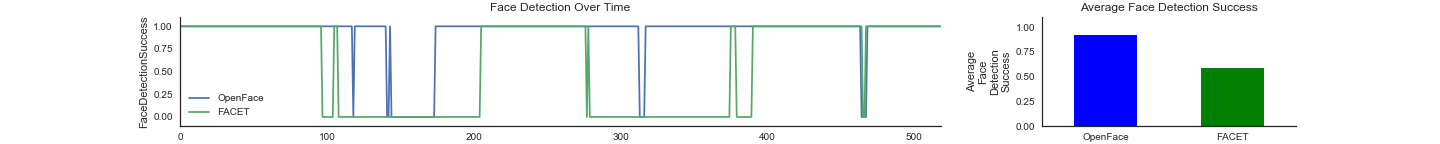

In [36]:
# Figure 1
# Load Rotation Data
of_rotation_f = 'Data/separate_rotation_of.csv'
fa_rotation_f = 'Data/separate_rotation_facet.txt'

of_rotation = pd.read_csv(of_rotation_f)
of_rotation.columns = [col.replace(' ','') for col in of_rotation.columns]

fa_rotation = pd.read_csv(fa_rotation_f,sep='\t',skiprows=5)

# Plot Face Detection Results on Rotating Head. 
sns.set_style('white')
f,ax = plt.subplots(1,2,figsize=(20,2), gridspec_kw = {'width_ratios':[3, 1]})
pd.DataFrame([of_rotation['success'], fa_rotation['NoOfFaces']],index=['OpenFace','FACET']).T.plot(ax=ax[0])
ax[0].set(xlabel="Frames", ylabel="FaceDetectionSuccess",title = 'Face Detection Over Time',ylim=[-.1,1.1])

pd.DataFrame([of_rotation['success'].mean(),fa_rotation['NoOfFaces'].mean()],index=['OpenFace','FACET']).plot(kind='bar',legend=False,ax=ax[1],rot=0,color=['b','g'])
ax[1].set(xlabel="Software", ylabel="Average\nFace\nDetection\nSuccess",title = 'Average Face Detection Success',ylim=[0,1.1])
sns.despine();plt.show(); 

One thing to note however is that OpenFace success does not necessarily mean that it's doing a perfect job.   
The OpenFace provides confidence measure for its face detection success showing that confidence does suffer in profile head views. 

<IPython.core.display.Javascript object>


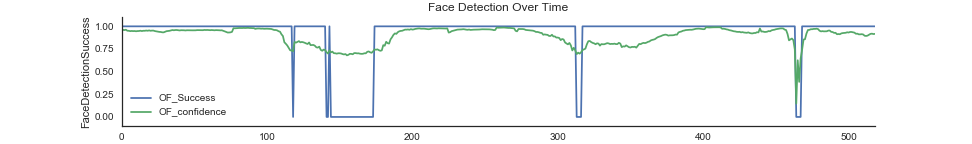

In [35]:
f,ax = plt.subplots(figsize=(13.5,2))
pd.DataFrame([of_rotation['success'], of_rotation['confidence']],index=['OF_Success','OF_confidence']).T.plot(ax=ax)
ax.set(xlabel="Frames", ylabel="FaceDetectionSuccess",title = 'Face Detection Over Time',ylim=[-.1,1.1])
sns.despine(); plt.show()

The importance of face detection is that if the algorithm cannot find a face, it cannot provide facial expression predictions. 

In OpenFace, face detection failure does not provide NAN values for predictions but instead 0s.   
Therefore one must be careful when interpreting the absence of AUs as a true absence or a result of face detection failure.   
This is represented around frame 150 in the graph below.

In contrast, FACET records NAN values for AU predictions when it cannot identify a face. 
This is represented by the discontinued green lines between frames 100 - 200 in the plot below. 

[(-1, 3), <matplotlib.text.Text at 0x132771860>]

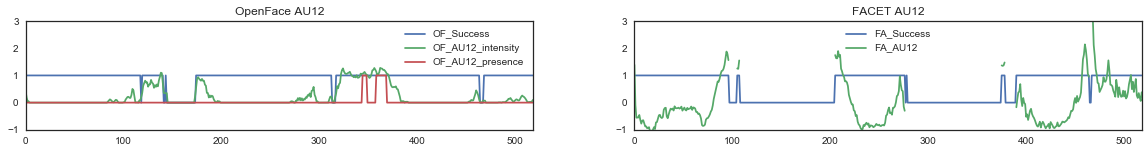

In [310]:
f,ax = plt.subplots(1,2,figsize=(20,2))
pd.DataFrame([of_rotation['success'], of_rotation['AU12_r'], of_rotation['AU12_c']],index=['OF_Success','OF_AU12_intensity','OF_AU12_presence']).T.plot(ax=ax[0])
ax[0].set(ylim=[-1,3],title='OpenFace AU12')
demeaned = fa_rotation['AU12 Evidence']-fa_rotation['AU12 Evidence'].mean()
pd.DataFrame([fa_rotation['NoOfFaces'], demeaned],index=['FA_Success','FA_AU12']).T.plot(ax=ax[1])
ax[1].set(ylim=[-1,3],title='FACET AU12')

### Conclusion
OpenFace provides a better face detection algorithm. 


# Facial AU predictions comparison to genuine facial expressions of emotion

Here I compare the AU predictions between OpenFace and FACET on a facial expression recording we conducted while a participant watched a TV drama. 

But first of all, let's review the meaning of facial expression estimates from each software.

OpenFace provides both AU intensity (e.g., AU12_r) and AU presence (e.g., AU12_c).  
The intensity is on a 5 point scale (0:not present to 5:maximum intensity) representing the degree of activation.
AU presence indicates whether an AU is visible on the face as a binary outcome. 

FACET deprecated providing intensity or probabilities of AUs in recent versions and now provides Action Unit Evidence (e.g., AU12 Evidence).  
The evidence represents a logarithmic odds of an action unit or expression being present and can be considered as Z-scores on which statistical analyses should be performed. 
The Z-scores can be baselined and/or be transformed to probabilities using the following softmax function:

$ P(AU) = \frac{1}{ 1 + 10 ^ Evidence} $

With these differences in mind, let's compare how similar the AU predictions are between the two software. 

In [2]:
# load data
import numpy as np
of_au_f = 'Data/sra_ep01_of.csv'
fa_au_f = 'Data/sra_ep01_facet.txt'

of_au = pd.read_csv(of_au_f)
of_au.columns = [col.replace(' ','') for col in of_au.columns]
fa_au = pd.read_csv(fa_au_f,sep='\t',skiprows=5)

# downsample from 120hz to 1 hz 
from nltools.stats import downsample
of_au = downsample(of_au,sampling_freq=120,target=30,target_type='hz')
fa_au = downsample(fa_au,sampling_freq=120,target=30,target_type='hz')

of_au.columns = [col.replace('_r','_OF').replace('U0','U') for col in of_au.columns]
fa_au.columns = [col.replace(' Evidence','_FA') for col in fa_au.columns]

First, comparing the AU prediction similarity shows that the coherence is rather low (mean r = .28; blue bars on bottom graph).   
This however includes the average negative correlations of AU17 (Chin Raiser).  
The more widely used / distinct expressions AU10(upper lip raiser), AU12(lip corner puller), AU23(lip tightener), AU25(lips part) are decently correlated (around r = .5).    

But one reason for this low correlation could be that they operate on different scales as mentioned above.    
OpenFace predictions has a minimum value of 0 whereas FACET provides continous predictions which can also decrease the covariance.   
I recalculated the correlations after removing the bottomed-out zero values but does not result in huge correlation increases (green bars on bottom graph).  
And also after converting FACET's AU Evidence to Probabilities using a softmax function.   
The correspondence between the two increases substantially to about r = .6 for AUs 10, 12, and 25.  

It is quite important to note that for AUs 15, 17 there is no similarity between the two predictions which warrants further inspection.   

This result is quite surprising yet interesting in that the two algorithms are relying on different features for their AU predictions.  

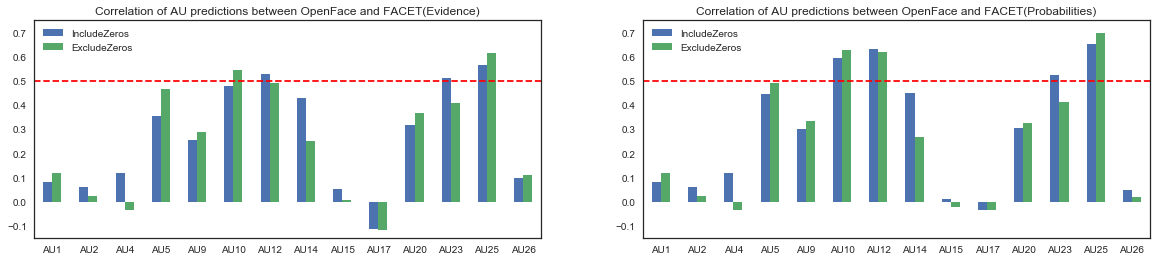

In [51]:
%matplotlib inline
aulist = ['AU1','AU2','AU4','AU5','AU9','AU10','AU12','AU14','AU15','AU17','AU20','AU23','AU25','AU26']
similarities, similarities_nonzero,similarities_p, similarities_nonzero_p=[],[],[],[]
for au in aulist: 
    x=of_au[[col for col in of_au.columns if au in col and '_c' not in col]]
    y=fa_au[[col for col in fa_au.columns if au in col]]
    yp=y.apply(softmax)
    similarities.append(pd.concat([x,y],axis=1).corr().iloc[0,1])
    similarities_nonzero.append(pd.concat([x.replace({0.0:np.nan}),y],axis=1).corr().iloc[0,1])
    similarities_p.append(pd.concat([x,yp],axis=1).corr().iloc[0,1])
    similarities_nonzero_p.append(pd.concat([x.replace({0.0:np.nan}),yp],axis=1).corr().iloc[0,1])
f,ax = plt.subplots(1,2, figsize=(20,4))
pd.concat([pd.DataFrame(similarities,index=aulist,columns=['IncludeZeros']),
           pd.DataFrame(similarities_nonzero,index=aulist,columns=['ExcludeZeros']) ],
          axis=1).plot(kind='bar',rot=0,ax=ax[0])
ax[0].set(ylim=[-.15,.75],title='Correlation of AU predictions between OpenFace and FACET(Evidence)')
ax[0].axhline(y=.5,color='r',linestyle='--')
pd.concat([pd.DataFrame(similarities_p,index=aulist,columns=['IncludeZeros']),
           pd.DataFrame(similarities_nonzero_p,index=aulist,columns=['ExcludeZeros']) ],
          axis=1).plot(kind='bar',rot=0,ax=ax[1])
ax[1].set(ylim=[-.15,.75],title='Correlation of AU predictions between OpenFace and FACET(Probabilities)')
ax[1].axhline(y=.5,color='r',linestyle='--')

We can also compare the facial expression predictions from each software with the actual facial expression images. 
Here is a participant smiling at two different timepoints which provides a few interesting insights.

## Comparing AU12 (Lip Corner Puller)
AU12 prediction is important because it is indicative of a smile and experience of joy.  

Comparing the two instances of AU12 activation at 17:10 (top image) and at 20:00 (bottom image), it seems like FACET provides a more accurate prediction.   
Note: OpenFace y-axis is intensity and the FACET y-axis is the probability of activation.  

The reason for this is that the AU12 definitely seems more activate at 17:10 than at 20:00 which is reflected by FACET predictions but the opposite in OpenFace predictions.


In [5]:
%matplotlib notebook

Video(layout=Layout(align_self='center', width='640px'), src='http://127.0.0.1:57138//sra_ep01.MP4?v=wETUMeJsw8FPL4FnTBnsTM', timebase=0.03333333333333333)

<IPython.core.display.Javascript object>


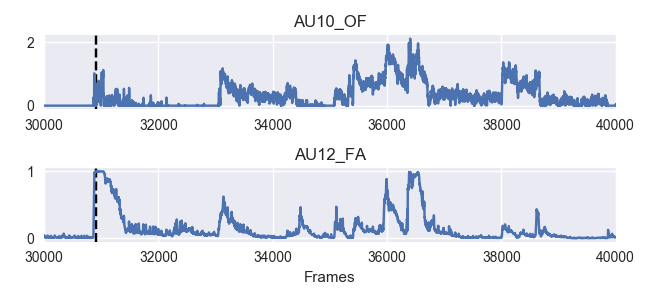

In [6]:
#17:10
utils.VideoViewer(path_to_video='Data/sra_ep01.MP4' ,data_df=pd.concat([of_au['AU10_OF'],fa_au['AU12_FA'].apply(softmax)],axis=1),xlim=[30000,40000],plot_rows=True)

Video(layout=Layout(align_self='center', width='640px'), src='http://127.0.0.1:57334//sra_ep01.MP4?v=A2EWuUauppnN76Nmbp4VP5', timebase=0.03333333333333333)

<IPython.core.display.Javascript object>


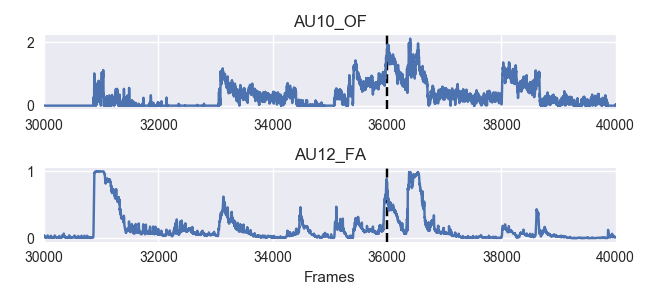

In [7]:
#20:00
utils.VideoViewer(path_to_video='Data/sra_ep01.MP4' ,data_df=pd.concat([of_au['AU10_OF'],fa_au['AU12_FA'].apply(softmax)],axis=1),xlim=[30000,40000],plot_rows=True)

## Comparing AU17 (Chin Raiser):   
It looks clear that they do have some correspondence in the first graph where both accurately determine the chin raise.   
However, in the bottom graph, OpenFace is noisily detecting a chin raise where as FACET provides a more stable prediction of no AU17.  
Also the tonic increase in AU17 predictions at around 35,000 frame is also puzzling and doesn't seem as accurate as FACET's predictions.  

Video(layout=Layout(align_self='center', width='640px'), src='http://127.0.0.1:57468//sra_ep01.MP4?v=F4Avv7XW8QCzwXq3WYCmoM', timebase=0.03333333333333333)

<IPython.core.display.Javascript object>


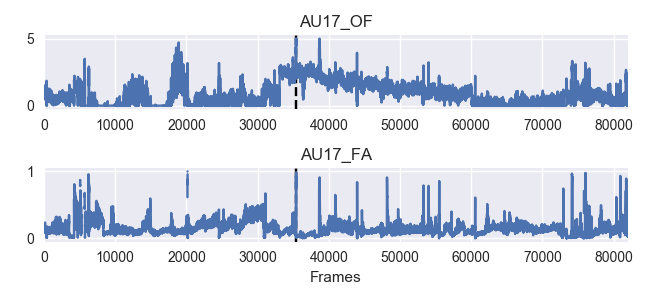

In [8]:
utils.VideoViewer(path_to_video='Data/sra_ep01.MP4' ,data_df=pd.concat([of_au['AU17_OF'],fa_au['AU17_FA'].apply(softmax)],axis=1),plot_rows=True)

Video(layout=Layout(align_self='center', width='640px'), src='http://127.0.0.1:57547//sra_ep01.MP4?v=esqTvSzquUCXMdgWyPfSaa', timebase=0.03333333333333333)

<IPython.core.display.Javascript object>


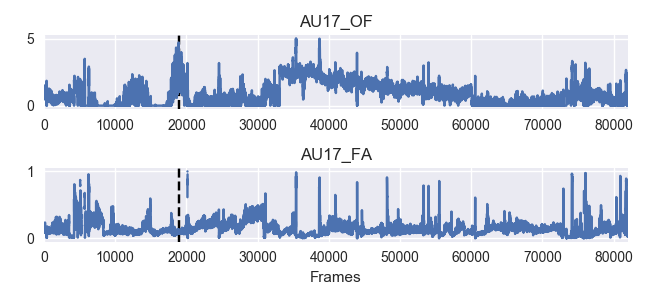

In [9]:
# Convergent chin raiser at 19:39 but different at 10:24
utils.VideoViewer(path_to_video='Data/sra_ep01.MP4' ,data_df=pd.concat([of_au['AU17_OF'],fa_au['AU17_FA'].apply(softmax)],axis=1),plot_rows=True)

# Conclusion

### 1. OpenFace has better face detection and can provide data even for profile view of faces. 
### 2. FACET, however, seems to have a more accurate representation of Action Unit activations. 

# Coming next
### Comparison with Affectiva.
### Training OpenFace with additional data. 